# Details
* [Datasheet](https://fair-rite.com/product/round-cable-emi-suppression-cores-2643625002/)
* Mouser : €0.70/pce
* Material : Type 43
* Size : OD 16.25mm, ID 7.9mm, H 14.3mm

# Measurements
## Measurement 1 : 1 turn
* f = 489.575kHz
* Z = 0.144 + 4.27j
* L = 1.39µH

Unfortunately, the datasheet doesn't list the Al value for this core.

# Construction

In [36]:
import sys
sys.path.insert(0, '../../Calculations/')
from calcInductors import *

turns_ratio = 7
Pmax = 5 # [W]
Zin = 50 #  [Ω]
fmin = 3e6 # [Hz]

d = 0.5e-3 # [m] wire diameter

# Fair-Rite 2643625002 (#43 material)
# Toroid
Al = 1390 # [nH/N²] Inductance factor (measured above)
Ae = 54.8e-6 # [m²] Effective cross-sectional area
Bmax = 0.22 # [T], from [Fair-rite materials](https://www.fair-rite.com/materials/): Inductive Materials
OD = 15.9e-3 # [m] outer diameter
ID = 7.90e-3 # [m] inner diameter
h = 14.30e-3 # [m] height
Lp_min = 13.5e-6 # [H] minimum required inductance

[Np, Ns] = calc_inductor_turns(Al, Lp_min, turns_ratio)
print("Required number of turns on primary winding: " + str(Np))
print("Required number of turns on secondary winding: " + str(Ns))

Required number of turns on primary winding: 4
Required number of turns on secondary winding: 28


Although 4:28 is suggested, let's start with 3:21.  The high frequency behaviour will probably be better with a lower turn count.

In [37]:
print("Primary coil wire length: " + str(calc_toroid_wirelength(OD, ID, d, h, Np))+"m")
print("Secondary coil wire length: " + str(calc_toroid_wirelength(OD, ID, d, h, Ns))+"m")

B = calc_max_flux_density(Ae, Pmax, Zin, fmin, Np)
print('Maximum flux density: {:.3}T'.format(B))
if B > Bmax:
    print("Error : Exceeding maximum flux density.")
else:
    print("Flux density OK.")

Primary coil wire length: 0.15m
Secondary coil wire length: 1.06m
Maximum flux density: 0.00542T
Flux density OK.


 <img src="IMG_20230823_215430_048.jpg" alt="bare transformer" width="500" > 

# Measurement 2 : 500kHz behaviour
Frequency : 489.575kHz
Secondary open : 0.897 + j37.1 ohm 
Secondary closed : 0.0628 + j0.502 ohm

In [38]:
import skrf as rf
from calcInductors import calcSRF, transformer_bandwidth_calculation

f = 489.575e3 # [Hz]
Z_open = 0.897 + 37.1j # [ohm]
Z_shorted = 0.0628 + 0.502j # [ohm]

# Measured SRF = 4.82MHz

filepath = './open_secondary_winding.s1p'

nw = rf.Network(filepath)

srf = calcSRF(nw)
print('SRF = {:.4}Hz and the resistance is {:.4}Ω'.format(srf[1], srf[0]))

transformer_bandwidth_calculation(f, srf[1], 2, 50, Z_open, Z_shorted)

SRF = 6.819e+06Hz and the resistance is 532.7Ω
Leakage inductance = 1.63e-07H
Magnetization inductance = 1.19e-05H
Al = 2.97e+03 nH/N²
Cw = 4.58e-11 F
Low frequency cut-off (fl) = 6.69e+05Hz
High frequency cut-off due to winding capacitance = 6.95e+07Hz
High frequency cut-off due to resonance of winding capacitance and leakage inductance = 5.82e+07Hz


# Measurement 3, no 100pF cap on primary

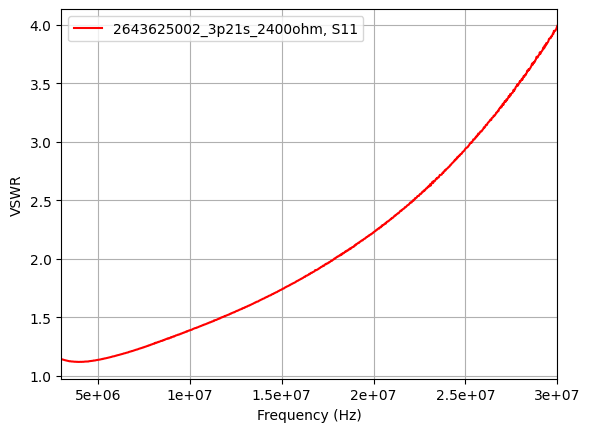

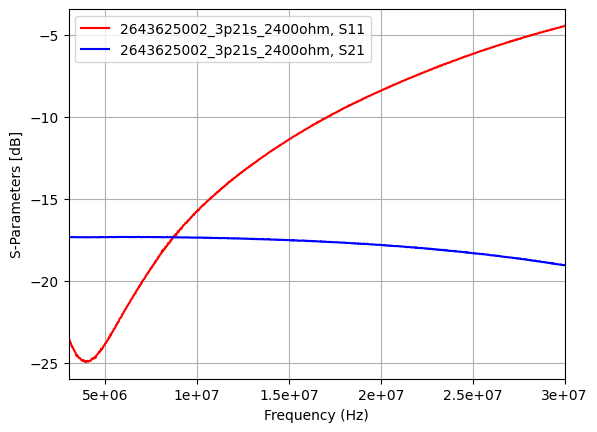

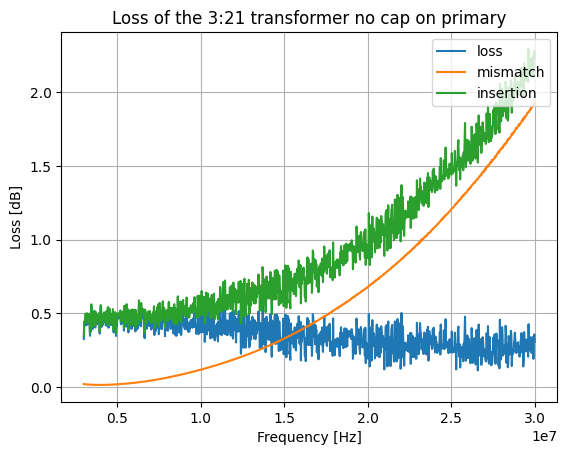

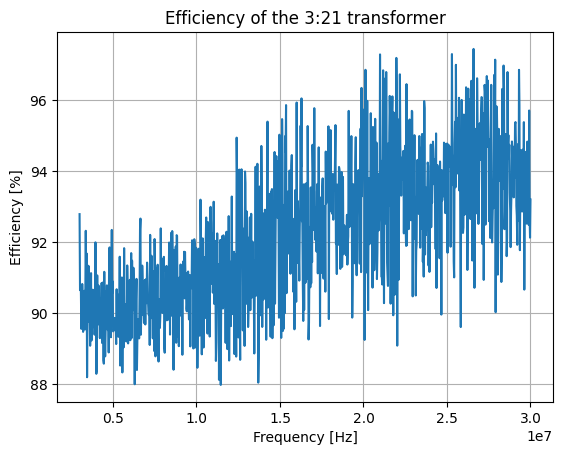

In [39]:
import skrf as rf
from plotResults import plot_s_parameters, plot_transformer_loss, plot_efficiency, plot_vswr

nw = rf.Network('./2643625002_3p21s_2400ohm.s2p')
nw_cal = rf.Network('./cal_2400ohm.s2p')
plot_vswr(nw)
plot_s_parameters(nw)
loss_db = plot_transformer_loss(nw, nw_cal, 'Loss of the 3:21 transformer no cap on primary')
plot_efficiency(nw.f, loss_db,'Efficiency of the 3:21 transformer')

# Measurement 4, 100pF cap on primary

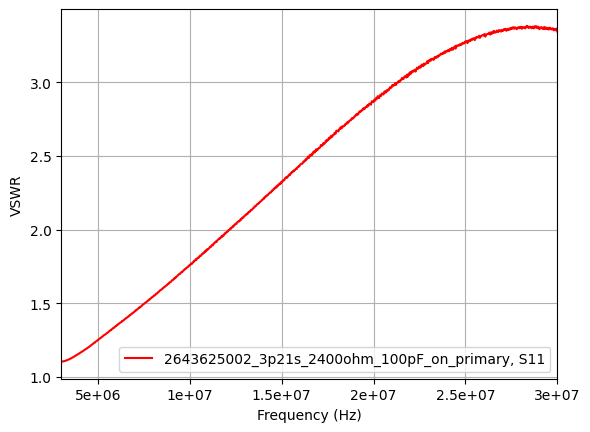

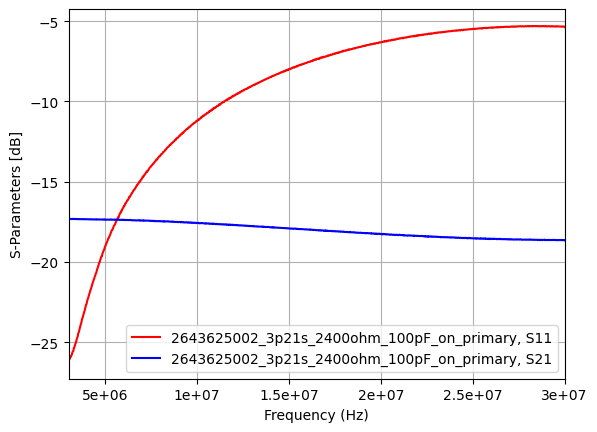

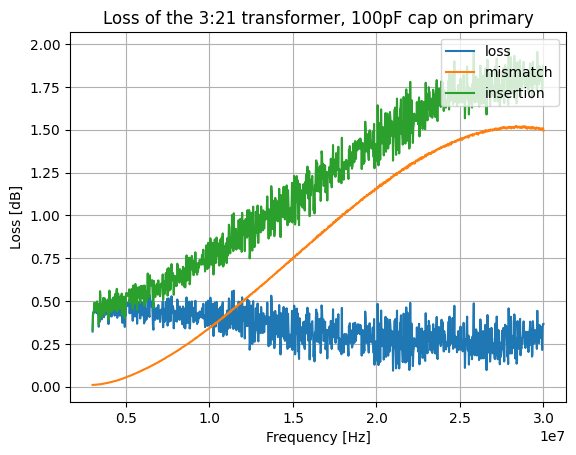

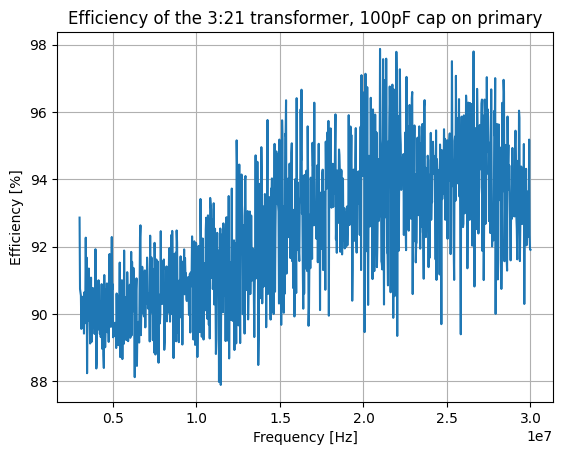

In [40]:
import skrf as rf
from plotResults import plot_s_parameters, plot_transformer_loss, plot_efficiency, plot_vswr

nw = rf.Network('./2643625002_3p21s_2400ohm_100pF_on_primary.s2p')
nw_cal = rf.Network('./cal_2400ohm.s2p')
plot_vswr(nw)
plot_s_parameters(nw)
loss_db = plot_transformer_loss(nw, nw_cal, 'Loss of the 3:21 transformer, 100pF cap on primary')
plot_efficiency(nw.f, loss_db,'Efficiency of the 3:21 transformer, 100pF cap on primary')

# Measurement 5, no capacitor on primary, built into Hammond enclosure
<img src="./open_housing.jpg" width="500"/>
<img src="vna_measurement_setup.jpg" height="500"/>

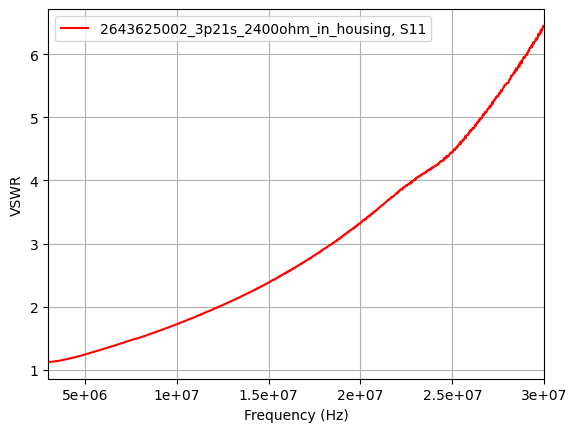

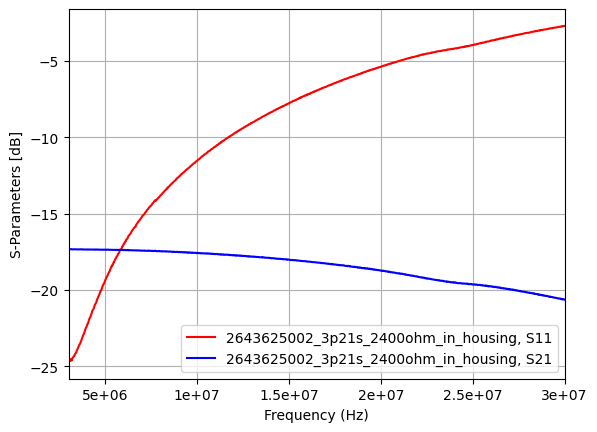

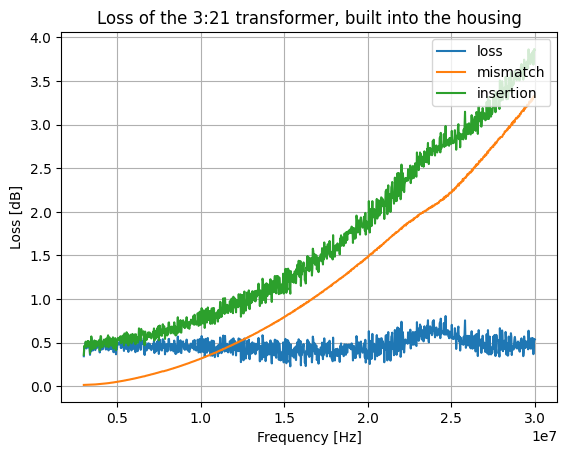

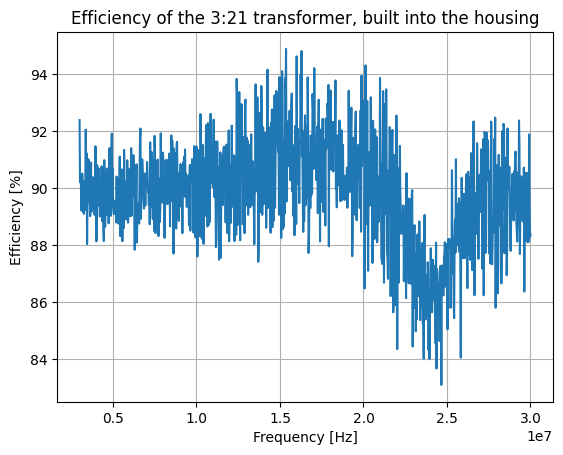

In [41]:
nw = rf.Network('./2643625002_3p21s_2400ohm_in_housing.s2p')
nw_cal = rf.Network('./cal_2400ohm.s2p')
plot_vswr(nw)
plot_s_parameters(nw)
loss_db = plot_transformer_loss(nw, nw_cal, 'Loss of the 3:21 transformer, built into the housing')
plot_efficiency(nw.f, loss_db,'Efficiency of the 3:21 transformer, built into the housing')

As pointed out on [Engineering the EFHW 49:1 Transformer and Antenna](https://squashpractice.com/2021/07/20/engineering-the-efhw-491-transformer-and-antenna/), the output capacitance increases considerably when mounted into a box.  The solution is to add inductance on the antenna wire, near the transformer.

# Measurement 6, 100pF cap on primary, built into Hammond enclosure

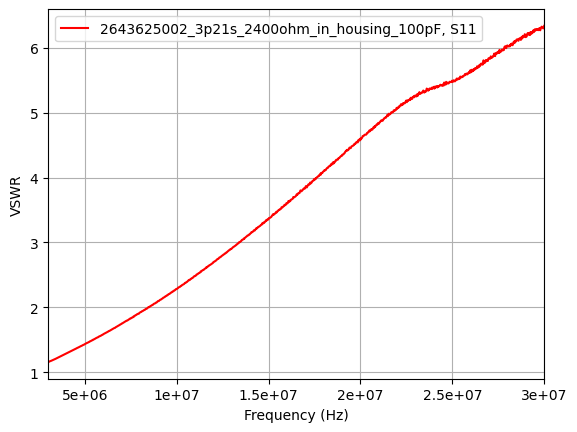

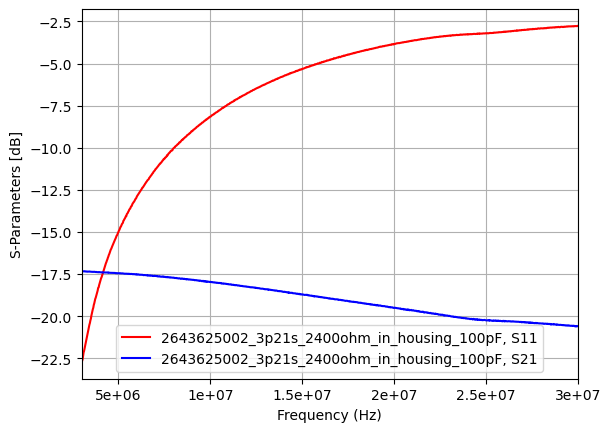

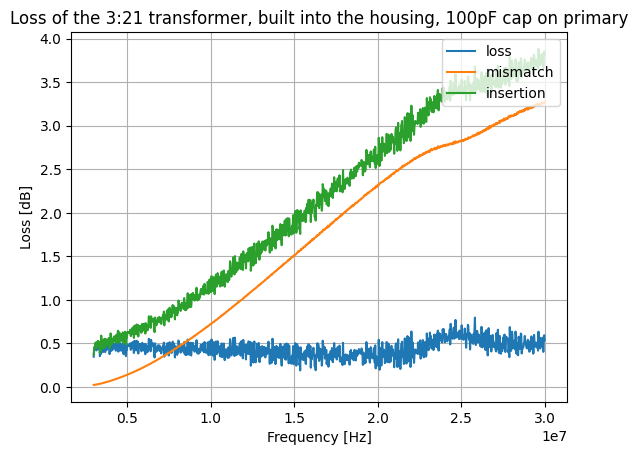

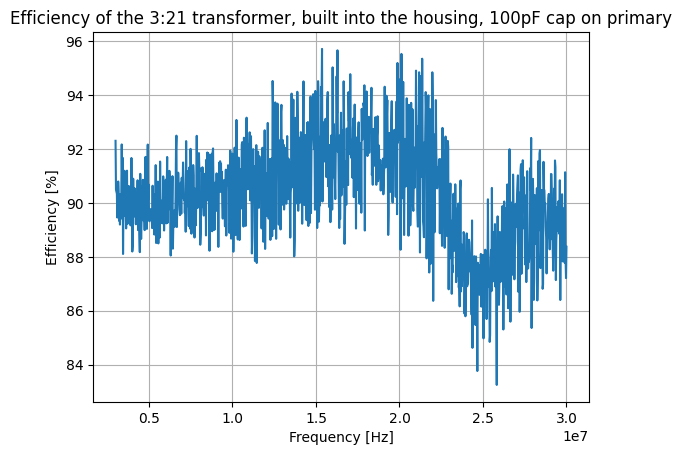

In [42]:
nw = rf.Network('./2643625002_3p21s_2400ohm_in_housing_100pF.s2p')
nw_cal = rf.Network('./cal_2400ohm.s2p')
plot_vswr(nw)
plot_s_parameters(nw)
loss_db = plot_transformer_loss(nw, nw_cal, 'Loss of the 3:21 transformer, built into the housing, 100pF cap on primary')
plot_efficiency(nw.f, loss_db,'Efficiency of the 3:21 transformer, built into the housing, 100pF cap on primary')

The 100pF cap doesn't seem to make a difference.  The VSWR is still bad.

# Conclusion
* Low loss throughout the HF range
* cheap
* small
* no capacitor required

# Reference
* [The End Fed Halfwave antenna, Steve Dick, K1RF](http://gnarc.org/wp-content/uploads/The-End-Fed-Half-Wave-Antenna.pdf), p.25 suggests: 3p:21s turns, 100pF capacitor
* [MM0OPX : End Fed Half Wave Transformers.......Are they as good as we think?](https://youtu.be/nZ-G4hJCTSM?t=858)
* [Owen Duffy : Small efficient matching transformer for an EFHW](https://owenduffy.net/blog/?p=12642)